# 🏡House Price Prediction Model(Neural Network)

## Overview

The dataset is about california house features and prices. The data object has different properties about the house such as number of rooms, bedrooms, size, age of the house, longitude and lattitude. We need to predict the `Price` of the house by considering the attributes of the house. 


## Import Required Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing


import tensorflow as tf
from tensorflow import keras

np.random.seed(0)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Load Dataset

In [ ]:
house_data = pd.read_csv("/kaggle/input/california-housing-prices/housing.csv")

print(house_data.columns)

# Drop text variable
house_data = house_data.drop('ocean_proximity', axis=1)

In [ ]:
feature_cols = ['median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'latitude', 'longitude']

target_col = 'median_house_value'


In [ ]:
# Getting feature and target data
X = house_data[feature_cols]
y = house_data[target_col]



## Exploratory Analysis


In [ ]:
house_data.describe().T

### Transform the "Price" to lower value

The price of the house is in thousands. The **max amount** is **500K** and the min value is **14.9K**. We will make it a smaller number by divide them by 100K.

In [ ]:
# Apply divide the amount by 100K
house_data['median_house_value'] = house_data['median_house_value'].apply(lambda n: n/100000)

## Split the data

In [ ]:
# Spliting data into Train, Holdout and Test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the train data for holdout set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [ ]:
def standardize(X_train, X_valid, X_test):
    """
    :param X_train, X_test: training set and test set
    """
    # scaler object
    scaler = StandardScaler()
    
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test) # test or valid data
    
    return X_train_scaled,X_valid_scaled, X_test_scaled
    

# Standardize the data
X_train_scaled, X_valid_scaled, X_test_scaled = standardize(X_train, X_valid, X_test)
    

In [ ]:
X_train_scaled.shape[1]

# Model building

The network of the model as 1 input/hidden layer and 1 output layer. 

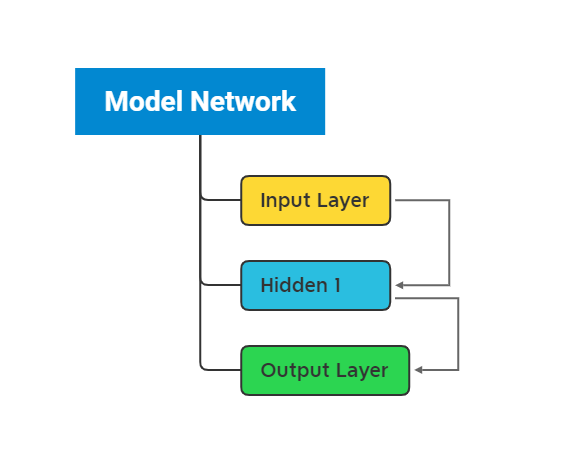

In [ ]:
# Model based on sequential API
def build_sequential(n_units=30):
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(n_units, activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(keras.layers.Dense(1))
    
    return model


In [ ]:
model = build_sequential()

model.summary()

In [ ]:
# Compile the model
model.compile(loss='mean_squared_error',
             optimizer='sgd',
             metrics=['mae'])

# fit the model with data
history = model.fit(X_train_scaled, y_train,
                   epochs=20,
                   validation_data=(X_valid_scaled, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                   verbose=1)



## Building Functional API


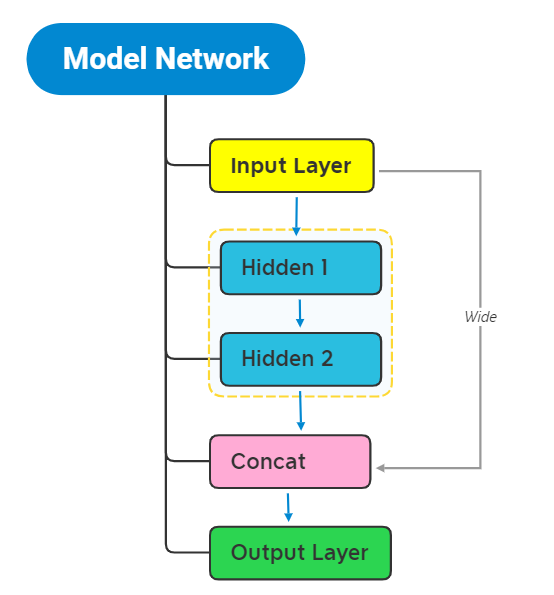

In [ ]:
def functional_model():
    
    input_layer = keras.layers.Input(shape=(X_train_scaled.shape[1],))
    
    hidden_1 = keras.layers.Dense(30, activation='relu')(input_layer) # Passing layer as parameter
    hidden_2 = keras.layers.Dense(30, activation='relu')(hidden_1)
    
    concat = keras.layers.Concatenate()([input_layer, hidden_2]) # concatinates input and output of second layer
    output_layer = keras.layers.Dense(1)(concat)
    
    model = keras.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model
    
# build model
model_b = functional_model()

model_b.summary()
    

In [ ]:
# Compile the model
model_b.compile(loss='mean_squared_error',
             optimizer='sgd',
             metrics=['mae'])

# fit the model with data
history = model_b.fit(X_train_scaled, y_train,
                   epochs=20,
                   validation_data=(X_valid_scaled, y_valid),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
                   verbose=1)

## Functional Model handline multiple input


This approach allows to send a subset of features through the wide path and a different subset through deep path.



In [ ]:
 X_train_scaled[:, 1:]

In [ ]:
# Splite 
X_train_A, X_train_B = X_train_scaled[:, :5], X_train_scaled[:, 1:]
X_valid_A, X_valid_B = X_valid_scaled[:, :5], X_valid_scaled[:, 1:]

X_test_A, X_test_B = X_test_scaled[:, :5], X_test_scaled[:, 1:]

In [ ]:
input_A = keras.layers.Input(shape=(5,), name='wide_input')
input_B = keras.layers.Input(shape=(6,), name='deep_input')

hidden_1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden_2 = keras.layers.Dense(30, activation='relu')(hidden_1)

concat = keras.layers.Concatenate()([input_A, hidden_2])

output = keras.layers.Dense(1, name='output')(concat)

multi_model = keras.Model(inputs=[input_A, input_B], outputs=[output])

multi_model.summary()

In [ ]:
# Compile the model
multi_model.compile(loss='mse',
             optimizer=keras.optimizers.SGD(lr=1e-3),
                   metrics=['mae'])

history = multi_model.fit((X_train_A, X_train_B), 
                    y_train,
                   validation_data=((X_valid_A, X_valid_B), y_valid),
                   epochs=20,
                   verbose=1)

result = multi_model.evaluate((X_test_A, X_test_B), y_test)

print(result)